In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

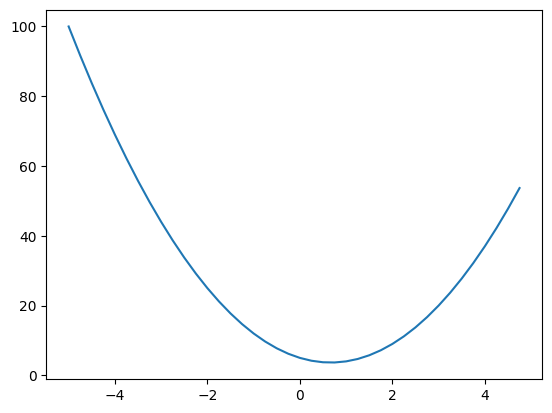

In [9]:
xs = np.arange(-5,5,.25)
ys = f(xs)
plt.plot(xs, ys)

Understanding derivitives

In [30]:
h =0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [33]:
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c+=h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [447]:
class Value:
    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
        
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = Value(math.exp(x), (self, ), 'exp')
        out._backward = _backward
        return out

    def __truediv__(self, other): 
        return self * other**-1

    def __neg__(self): 
        return self * -1

    def __radd__(self, other): 
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    



In [431]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [448]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [449]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# x1*w1  + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'
o.backward()

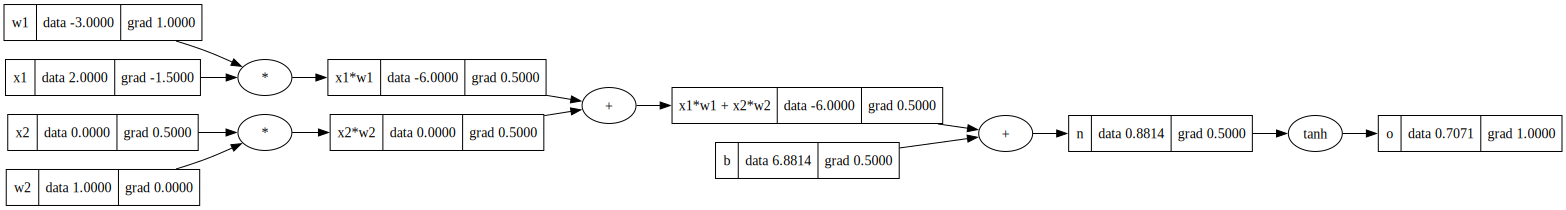

In [450]:
draw_dot(o)

In [435]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')
# x1*w1  + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#------
e = (2*n).exp()
o = (e-1)/(e+1)
#------
o.label='o'
o.backward() 

In [456]:
import random


In [483]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [488]:
n.parameters()

[Value(data=-0.17059712346366562),
 Value(data=-0.4980006007541624),
 Value(data=-0.39224921323538964),
 Value(data=-0.4340650059440907),
 Value(data=-0.640206383912076),
 Value(data=-0.004553125968647098),
 Value(data=0.13832495188151284),
 Value(data=-0.00951284491064075),
 Value(data=-0.6849490198697048),
 Value(data=0.40036627127526647),
 Value(data=-0.852561434691036),
 Value(data=0.7931382982841968),
 Value(data=-0.0359820479957349),
 Value(data=-0.5648123659944064),
 Value(data=-0.30252823959410646),
 Value(data=-0.5446994589646998),
 Value(data=0.17776413359755483),
 Value(data=0.39981388118849814),
 Value(data=-0.2407209917912878),
 Value(data=0.8759535473494715),
 Value(data=0.06889233106716386),
 Value(data=-0.7579932625050785),
 Value(data=-0.4237622502712408),
 Value(data=-0.3404245181527037),
 Value(data=-0.8444086784133022),
 Value(data=0.9293611848393595),
 Value(data=-0.6800940496998022),
 Value(data=0.47793968443990087),
 Value(data=0.999328963492983),
 Value(data=0.5

In [866]:


x = [2.0, 3.0, -1,0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.924845751448787)

In [867]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets


In [868]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.0986315787961734e-05)

In [869]:
for k in range(2000):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss
    #backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad 
    print(k, loss.data)

0 7.714321640356914
1 7.4952818333499085
2 7.222846756881718
3 6.65513619942514
4 5.261303759951758
5 3.273218357611117
6 2.7553065524682667
7 2.223349996405225
8 1.596753545738507
9 1.0216851504847901
10 0.6433585440841918
11 0.43400608508600436
12 0.3157215125014102
13 0.2435593955382817
14 0.19615660960471518
15 0.16310339536244836
16 0.13895061899361166
17 0.12063591572348623
18 0.10632932026046829
19 0.09487945890659838
20 0.08552996298659957
21 0.07776555927346392
22 0.07122420863261981
23 0.06564470790825139
24 0.06083423406465646
25 0.056647565596495225
26 0.05297338884880272
27 0.04972503977059284
28 0.04683410068417043
29 0.044245880902954476
30 0.041916168318115815
31 0.039808855808083965
32 0.03789418081362293
33 0.03614740182390251
34 0.03454779090267936
35 0.033077857995879936
36 0.0317227473943864
37 0.030469763568775097
38 0.02930799528264834
39 0.028228015117464835
40 0.027221637405337736
41 0.02628172179588195
42 0.025402012768297066
43 0.024577007673687173
44 0.02380

In [845]:
ypred

[Value(data=0.9999933499814978),
 Value(data=-0.9990671058777089),
 Value(data=-0.9999999618112383),
 Value(data=0.9999940544458267)]

## KEY Takeaways

What are nn?
mathematical expression that take input as data and the weight and parameters of the network. followed by a forward pass followed by a loss function(to measure loss). Then backward the loss(backprop) to get the gradient then tune the parameters to decrease the loss and do this iteratively many times which is called the gradient decent(means follow the gradient information).